# 最终结果


## 1. 生成特征数据


读取数据


In [1]:
from Network import *
import pandas as pd
import torch

# 选取需要的列
COLUMN_INDEX = [
    "Temp (°C)",
    "Dew Point Temp (°C)",
    "Rel Hum (%)",
    "Wind Spd (km/h)",
    "Stn Press (kPa)",
]
data = pd.read_csv("Data/DataSet.csv")[COLUMN_INDEX].to_numpy()
data_tensor = torch.tensor(data, dtype=torch.float32)

生成特征并保存


In [2]:
layer_1, layer_2 = 8, 16
ENCODER = MyAutoencoder(5, layer_1, layer_2, dropout_prob=0).encoder
DECODER = MyAutoencoder(5, layer_1, layer_2, dropout_prob=0).decoder
ENCODER.load_state_dict(torch.load("Networks/eDMDEncoder.pth"))

Header = [f"Feature {i+1}" for i in range(16)]

ENCODER.eval()
with torch.no_grad():
    feature_tensor = ENCODER(data_tensor)
    df = pd.DataFrame(data=feature_tensor.numpy(), columns=Header)

df.to_csv("Data/Feature.csv", index=True)

## 2. 线性回归得到传递矩阵


划分训练集和测试集


In [3]:
from Network import *

feature_tensor = torch.tensor(
    pd.read_csv("Data/Feature.csv")[Header].to_numpy(), dtype=torch.float32
)

# 设置随机种子以确保结果可重复
torch.manual_seed(42)
train_loader, test_loader = Split2Loaders(
    feature_tensor[:-1, :], feature_tensor[1:, :], BATCHSIZE=8, RATIO=0.7, SHUFFLE=True
)

定义线性回归模型


In [4]:
from torchinfo import summary

MyLinearRegression = LinearRegression(
    INPUT_SIZE=16, OUTPUT_SIZE=16, BIAS=False)
INIT_WEIGHTS_ZERO(MyLinearRegression)
summary(MyLinearRegression, (1, 16))

Layer (type:depth-idx)                   Output Shape              Param #
LinearRegression                         [1, 16]                   --
├─Linear: 1-1                            [1, 16]                   256
Total params: 256
Trainable params: 256
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

开始回归


In [5]:
optimizer = torch.optim.Adam(
    MyLinearRegression.parameters(), lr=0.005, weight_decay=1e-5
)
LOSS_HISTORY_TRAIN, LOSS_HISTORY_TEST = TRAIN_WITH_PROGRESS_BAR(
    MyLinearRegression,
    NUM_EPOCHS=30,
    OPTIMIZER=optimizer,
    TRAIN_LOADER=train_loader,
    TEST_LOADER=test_loader,
    LOSS_TYPE=nn.MSELoss(),
    DEVICE=0,
)

PyTorch Version: 2.1.0.dev20230621+cu117
Training on cuda:0
====================================Start training====================================


Epoch 30/30: 100%|██████████| 1533/1533 [00:01<00:00, 913.83batch/s, loss=0.0132] 


====================================Finish training====================================



可视化


/home/ctc/桌面/Git Projects/Optimization_Group_Work/Visualization.py:150: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/ctc/桌面/Git Projects/Optimization_Group_Work/Visualization.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/ctc/桌面/Git Projects/Optimization_Group_Work/Visualization.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/ctc/桌面/Git Projects/Optimization_Group_Work/Visualization.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/ctc/桌面/Git Projects/Optimization_Group_Work/

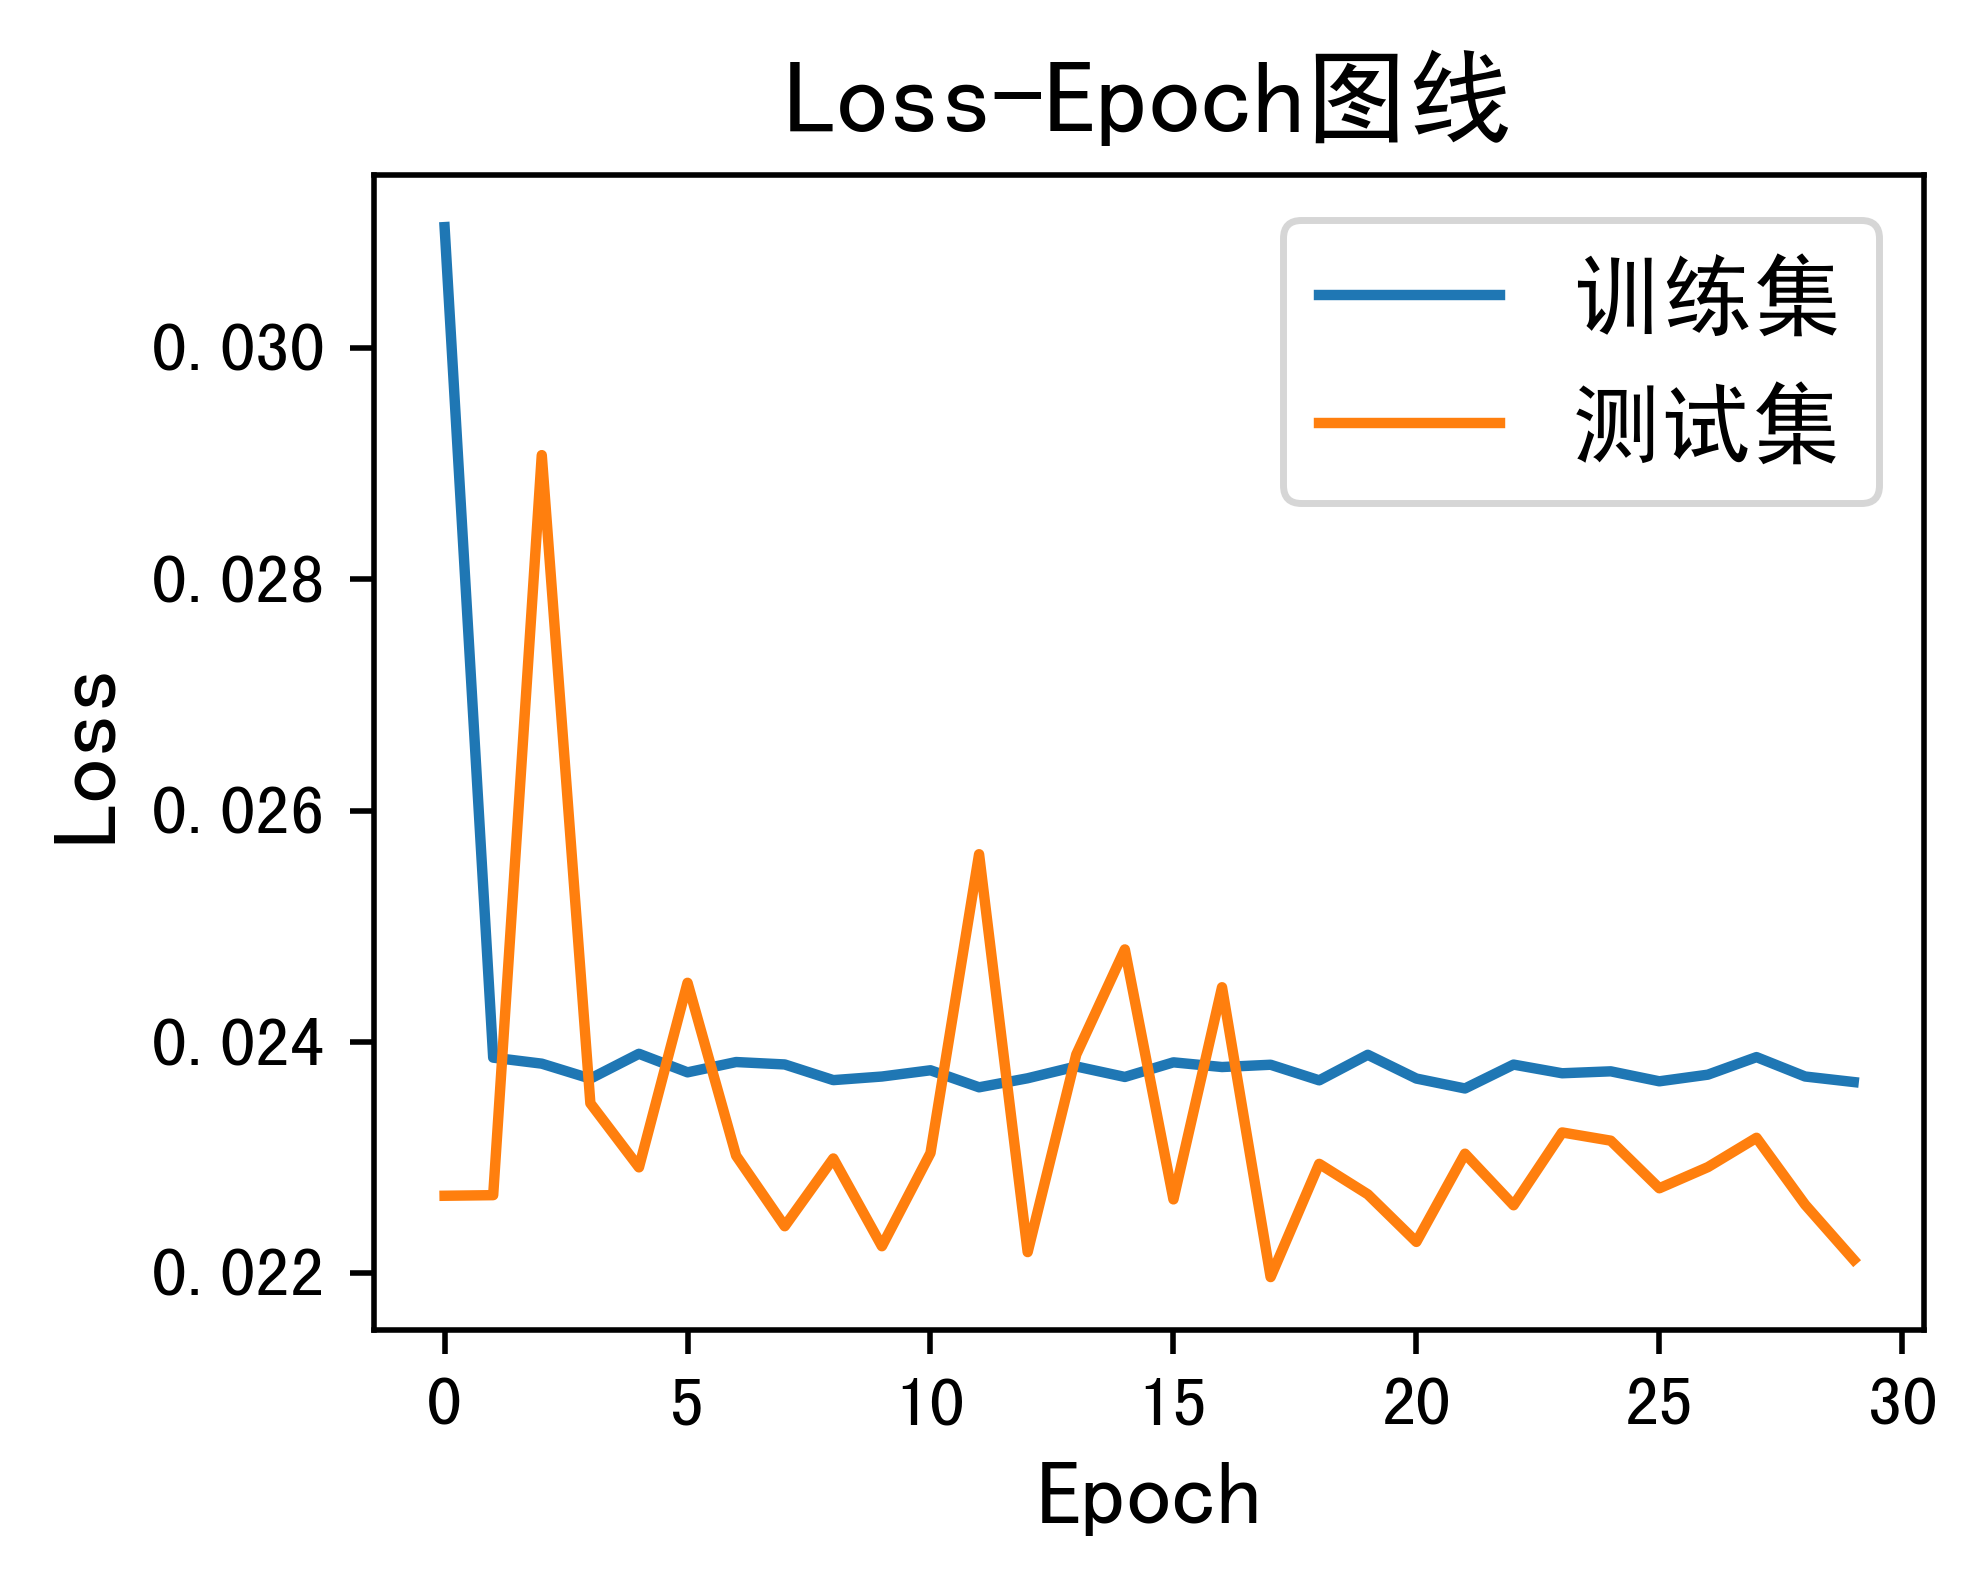

In [6]:
from Visualization import *

LossEpochPlot(
    LOSS_HISTORY=(LOSS_HISTORY_TRAIN, LOSS_HISTORY_TEST),
    LEGEND=["训练集", "测试集"],
    TITLE="Loss-Epoch图线",
    FILE_NAME="Images/06LinearRegression_Loss_Epoch.jpg",
    LOG_YAXIS=False,
    SAVE_FIG=True,
)

查看传递矩阵


In [7]:
TranferMatrix = MyLinearRegression.linear.weight.detach().cpu()
TranferMatrix

tensor([[ 2.9545e-01, -9.4660e-03, -1.0629e-02,  3.2161e-01,  4.4916e-01,
         -1.6786e-01,  2.7164e-01, -3.7610e-02,  1.9971e-01, -1.7007e-03,
          2.2271e-01, -6.7292e-02,  3.3359e-03,  7.8605e-02, -8.5528e-02,
          1.2708e-01],
        [-5.6366e-02,  2.1324e-01,  1.3795e-01, -1.8437e-01,  2.3407e-02,
         -3.9976e-02,  1.4109e-01,  5.3568e-02,  3.3344e-02, -9.7991e-02,
         -5.1338e-02, -7.9152e-03, -1.5952e-02, -2.5355e-02,  5.9675e-03,
          1.7731e-01],
        [ 4.0151e-02,  5.6439e-02,  6.0012e-01,  1.0426e-01, -4.1370e-02,
          1.5844e-02, -1.0132e-01, -3.5928e-02, -1.0647e-02,  1.5150e-01,
         -1.1971e-02,  8.0974e-04,  1.3828e-02,  2.6423e-02, -4.6758e-03,
          1.6171e-02],
        [ 2.7659e-01, -6.7904e-02, -2.0040e-01,  7.7327e-01, -1.6097e-02,
         -1.6506e-01, -2.6447e-01, -7.7738e-02, -1.2974e-01,  1.3250e-01,
         -2.2725e-02,  1.3591e-01,  2.4391e-02,  7.0661e-02, -5.5767e-02,
         -8.5089e-02],
        [ 1.6758e-01

检查模型的稳定性


/home/ctc/桌面/Git Projects/Optimization_Group_Work/Visualization.py:295: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/ctc/桌面/Git Projects/Optimization_Group_Work/Visualization.py:297: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/ctc/桌面/Git Projects/Optimization_Group_Work/Visualization.py:297: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/ctc/桌面/Git Projects/Optimization_Group_Work/Visualization.py:297: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/ctc/桌面/Git Projects/Optimization_Group_Work/

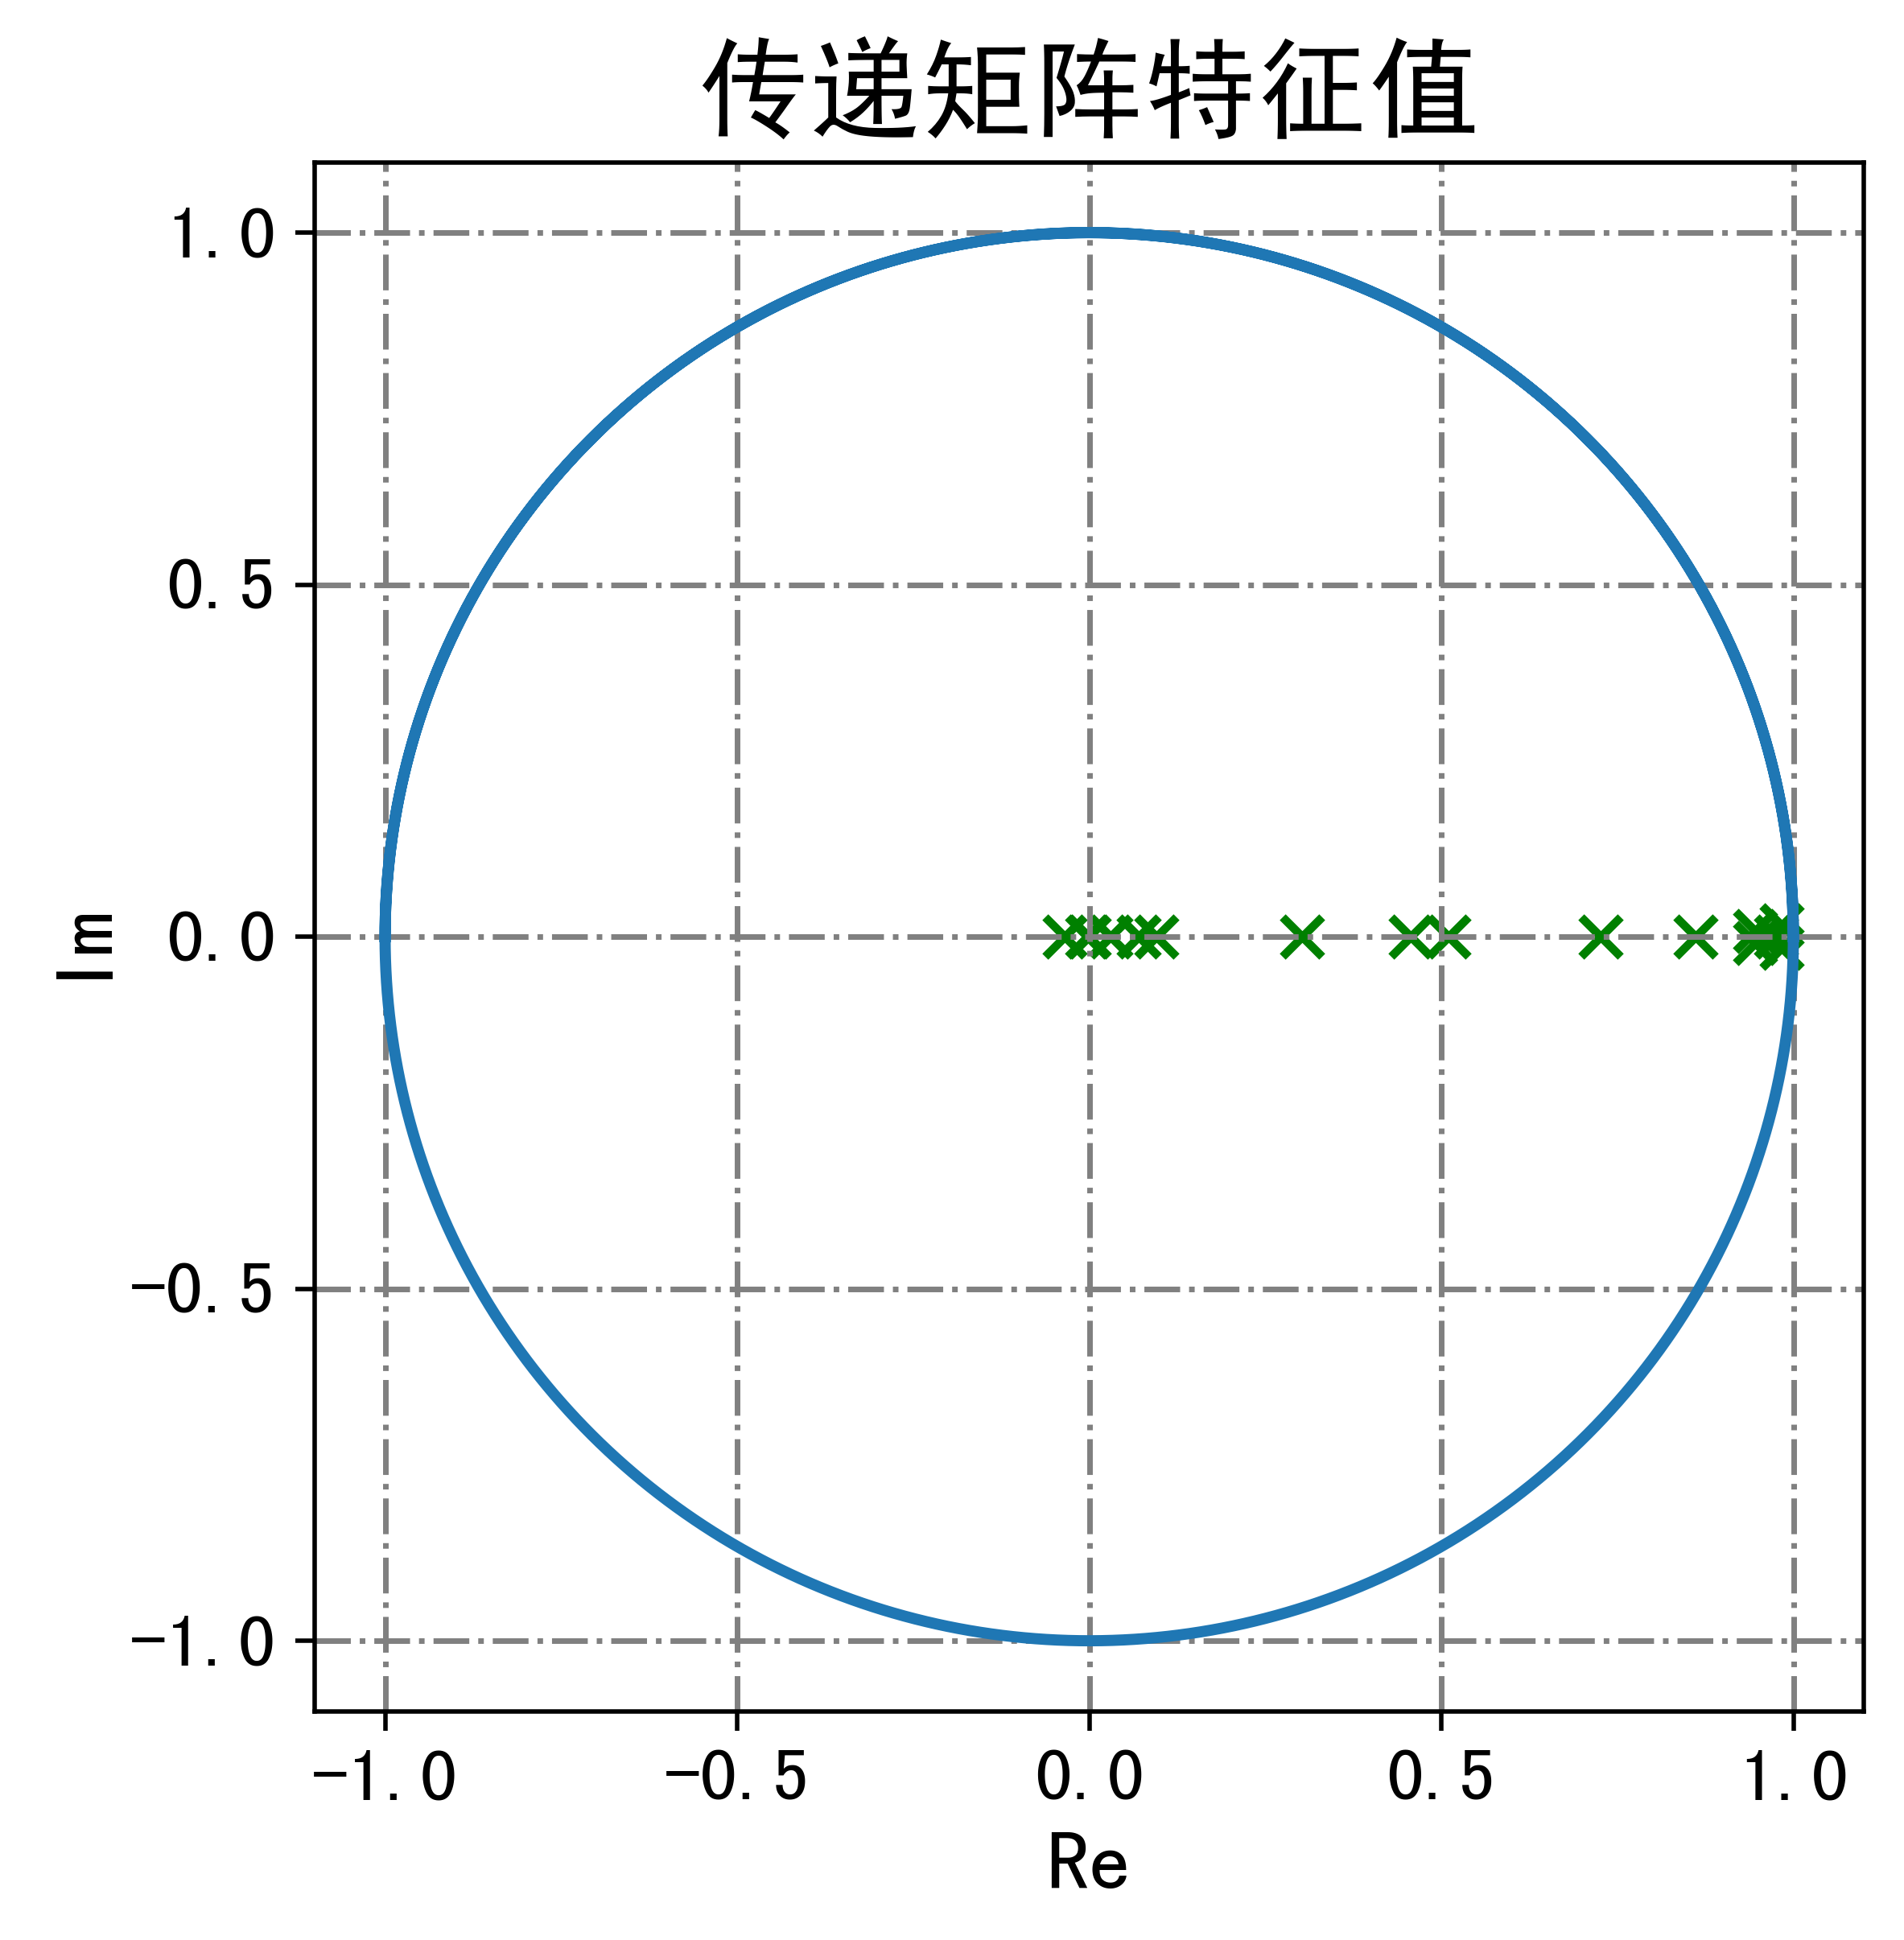

In [8]:
PlotEigenValues(
    TranferMatrix.numpy(),
    FONTSIZES=[13, 15, 20],
    FIG_SIZE=(5, 5),
    TITLE="传递矩阵特征值",
    SAVE_FIG=True,
)